In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns

import gc
import warnings
import os
import time

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

#warnings.simplefilter(action='ignore', category=FutureWarning)

print(os.listdir("Projet+Mise+en+prod+-+home-credit-default-risk"))

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))



['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
# Training data
#app_train = pd.read_csv('../Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
app_train = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Training data shape:  (307511, 122)
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [17]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    #check which cols are categorical 
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    #get dummy variables for categorical variables
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # put the two datasets together
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        # Encode the object as an enumerated type or categorical variable.
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df



In [18]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows = num_rows)

    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # bb is the df and bb_cat are the new cols
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    # in the new cols of the bureau balance
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
        #print(bb_aggregations)
        
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [6]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg



In [7]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [8]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', 
                      nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [9]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [10]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [11]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df


In [12]:
if __name__ == "__main__":
    with timer("Full model run"):
        df = main()
        df

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 15s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 26)
Process installments payments - done in 21s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 12s
Full model run - done in 77s


In [13]:
df.shape

(356251, 798)

In [14]:
# save df 
df.to_csv("df_for_modelling.csv")

In [33]:
# read the df 
main_model_df = pd.read_csv("df_for_modelling.csv")

In [7]:
main_model_df

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelling Start

## Create my own cost function and divide into test / train

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_comp_score(y_true, y_pred):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = (gain - baseline) / (best - baseline)
    
    return score

In [9]:
from sklearn.metrics import fbeta_score, make_scorer
make_scorer(my_comp_score)

make_scorer(my_comp_score)

In [10]:
import re

# Divide in training/validation and test data
main_model_df = main_model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = main_model_df[main_model_df['TARGET'].notnull()]
test_df = main_model_df[main_model_df['TARGET'].isnull()]


# Cross validation model
#if stratified:
#    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#else:
#    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
# Create arrays and dataframes to store results
feats = [f for f in train_df.columns if f not in ['TARGET', 'Unnamed: 0', 'Unnamed0',
                                                  'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# Sklearn stuff
#from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load and split dataset
#x, y = load_breast_cancer(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(train_df[feats], train_df['TARGET'], 
                                                    test_size=0.3, random_state = 22)



In [11]:
del test_df
gc.collect()

0

## Hyperparameter Search: from hyperopt

In [17]:
from hyperopt import fmin, tpe, hp, anneal, Trials

# HyperOpt: Optimizer
from hyperopt import tpe

kf = KFold(n_splits = 5)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def gb_mse_cv(params, random_state = 22, cv = kf, X = x_train, y= y_train):
    # the function gets a set of variable parameters in "param"
    params = {'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
              'subsample' : params['subsample'],
              'max_depth': int(params['max_depth']),
              'reg_lambda' : params['reg_lambda'],
              'min_data_in_leaf': int(params['min_data_in_leaf']),
              'min_split_gain' :  params['min_split_gain']
              }
    
    # we use this params to create a new LGBM Regressor
    model = LGBMClassifier(random_state = random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring= make_scorer(my_comp_score), 
                             n_jobs=-1).mean()

    return score


In [20]:
%%time

n_iter = 50

# possible values of parameters
space = {'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
         'subsample' : hp.loguniform('subsample', -4, 0),
         'max_depth' : hp.quniform('max_depth', 2, 14, 1),
         'reg_lambda' : hp.loguniform('reg_lambda', -4, 0),
         'min_data_in_leaf': hp.quniform('min_data_in_leaf', 2, 40, 1),
         'min_split_gain' : hp.loguniform('min_split_gain', -4, 0)
        }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(58) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMClassifier(random_state = 54,
                       learning_rate = best['learning_rate'],
                       num_leaves = int(best['num_leaves']), 
                       subsample = best['subsample'],
                       max_depth = int(best['max_depth']),
                       reg_lambda = best['reg_lambda'],
                       min_data_in_leaf = int(best['min_data_in_leaf']),
                       min_split_gain = best['min_split_gain']
                       )

model.fit(x_train, y_train)

print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))


100%|██████████| 50/50 [1:08:36<00:00, 82.32s/trial, best loss: -0.09539947444033699]
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Best  -0.095 params {'learning_rate': 0.7647979850346045, 'max_depth': 7.0, 'min_data_in_leaf': 35.0, 'min_split_gain': 0.10084477620937958, 'num_leaves': 32.0, 'reg_lambda': 0.8748371874180665, 'subsample': 0.5685052618291946}
CPU times: user 1min 19s, sys: 43.6 s, total: 2min 3s
Wall time: 1h 10min 20s


In [25]:
print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))

Best  -0.095 params {'learning_rate': 0.7647979850346045, 'max_depth': 7.0, 'min_data_in_leaf': 35.0, 'min_split_gain': 0.10084477620937958, 'num_leaves': 32.0, 'reg_lambda': 0.8748371874180665, 'subsample': 0.5685052618291946}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

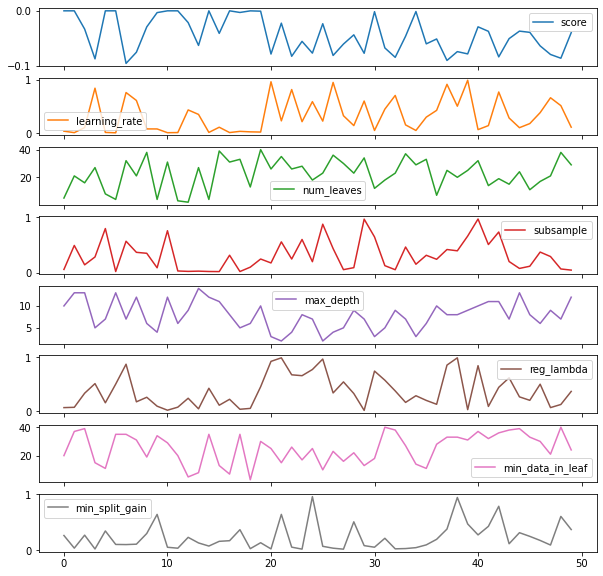

In [27]:
#tpe_test_score=mean_squared_error(x_test, model.predict(y_test))

tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['learning_rate'][0],
                       x['misc']['vals']['num_leaves'][0],
                       x['misc']['vals']['subsample'][0],
                       x['misc']['vals']['max_depth'][0],
                       x['misc']['vals']['reg_lambda'][0],
                       x['misc']['vals']['min_data_in_leaf'][0],
                         x['misc']['vals']['min_split_gain'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'num_leaves',
                                    'subsample',
                                    'max_depth',
                                    'reg_lambda',
                                    'min_data_in_leaf',
                                    'min_split_gain'])
                                    
tpe_results_df.plot(subplots=True,figsize=(10, 10))

In [28]:
model

LGBMClassifier(learning_rate=0.7647979850346045, max_depth=7,
               min_data_in_leaf=35, min_split_gain=0.10084477620937958,
               num_leaves=32, random_state=54, reg_lambda=0.8748371874180665,
               subsample=0.5685052618291946)

In [29]:
import pickle
import joblib

model_path = "hyperpar_search_output_lgbm"
#+ "/classification/models/"
#model, vectorizer_model = train_test_model(data["text"], data["category"])
joblib.dump(model, model_path+"model.sav")
#joblib.dump(vectorizer_model, model_path+"vectorizer.sav")
print ("====done saving into pickle using Joblib!====")

pickle.dump(model, open(model_path+"model.pickle", 'wb'))
#pickle.dump(vectorizer_model, open(model_path+"vectorizer.pickle", "wb"))
print ("====done saving into pickle using Pickle!====")

====done saving into pickle using Joblib!====
====done saving into pickle using Pickle!====


In [5]:
def loading_pickle(model_path):
    #vectorizer = pickle.load(open(model_path+"vectorizer.pickle",'rb'))
    model = pickle.load(open(model_path+"model.pickle",'rb'))
    return model
    #return vectorizer, model


def loading_joblibPickle(model_path):
    #vectorizer = joblib.load(model_path+"vectorizer.sav")
    model = joblib.load(model_path+"model.sav")
    return model 
    #return vectorizer, model

In [32]:
loading_pickle(model_path)

LGBMClassifier(learning_rate=0.6558478063333454, max_depth=5,
               min_data_in_leaf=21, n_estimators=784, num_leaves=33,
               random_state=54)

### HyperOpt-Sklearn Version

In [29]:
import hyperopt

hyperopt.tpe.suggest

<function hyperopt.tpe.suggest(new_ids, domain, trials, seed, prior_weight=1.0, n_startup_jobs=20, n_EI_candidates=24, gamma=0.25, verbose=True)>

In [ ]:
# HyperOpt-Sklearn 
from hpsklearn import HyperoptEstimator, gradient_boosting, ada_boost
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing


# Initialize Estimator
# classifier: The search is done for the complete suite of classifiers
# preprocessing: The preprocessing is donde for the complete suite of preprocessors
# algo: Optimizer algorithm (Tree-structure of Parzen Trees)
# max_evals: Number of iterations

# gradient_boosting

model = HyperoptEstimator(classifier = gradient_boosting('my_grad_boost'),
                          preprocessing=any_preprocessing('pre'), 
                          algo = hyperopt.tpe.suggest, 
                          max_evals=10, 
                          trial_timeout=30)

# Training
model.fit(x_train, y_train)

# Results
print(f"Train score: {model.score(x_train, y_train)}")
print(f"Test score: {model.score(x_test, y_test)}")

# Best model
print(f"Optimal configuration: {model.best_model()}")

## Launching the model

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_comp_score_lgbm(y_true, y_pred):
    
    # for now y_pred is the probability that the value is 1
    y_use = [1 if i >= 0.5 else 0 for i in y_pred]
    
    y_use = pd.Series(y_use)

    tn, fp, fn, tp = confusion_matrix(y_true, y_use).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = ((gain - baseline) / (best - baseline))

    return 'my score', score, True

In [34]:
main_model_df

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
import re

num_folds= 10
stratified= False
#debug= debug

# Divide in training/validation and test data
main_model_df = main_model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = main_model_df[main_model_df['TARGET'].notnull()]
test_df = main_model_df[main_model_df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del main_model_df
gc.collect()

# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

# Create arrays and dataframes to store results
feats = [f for f in train_df.columns if f not in ['TARGET', 'Unnamed: 0', 'Unnamed0',
                                                  'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]


Starting LightGBM. Train shape: (307507, 799), test shape: (48744, 799)


In [36]:
#Best  -0.089 params {'learning_rate': 0.6558478063333454, 'max_depth': 5.0, 'min_data_in_leaf': 21.0, 
# 'n_estimators': 784.0, 'num_leaves': 33.0}

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    train_x.to_csv("MY_train_x.csv")
    valid_x.to_csv("MY_valid_x.csv")
    valid_y.to_csv("MY_valid_y.csv")

    # LightGBM parameters found by Bayesian optimization
   #clf = LGBMClassifier(
   #    nthread=4,
   #    n_estimators=10000,
   #    learning_rate=0.02,
   #    num_leaves=34,
   #    colsample_bytree=0.9497036,
   #    subsample=0.8715623,
   #    max_depth=8,
   #    reg_alpha=0.041545473,
   #    reg_lambda=0.0735294,
   #    min_split_gain=0.0222415,
   #    min_child_weight=39.3259775,
   #    silent=-1,
   #    verbose=-1, )

    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.7,
        num_leaves = 32,
        max_depth = 7,
        reg_lambda = 0.8748371874180665,
        min_data_in_leaf = 35,
        subsample=.5685052618291946,
        min_split_gain = 0.10084477620937958,
        silent=-1,
        verbose=-1, )
        
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            verbose= 200, early_stopping_rounds= 200, eval_metric = my_comp_score_lgbm)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    valid_preds = clf.predict(valid_x, num_iteration = clf.best_iteration_)
    valid_preds_proba = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    #print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    #del clf, train_x, train_y, valid_x, valid_y
    #gc.collect()


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.132144	training's my score: 0.458805	valid_1's binary_logloss: 0.300073	valid_1's my score: 0.0943359
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.234047	training's my score: 0.0807007	valid_1's binary_logloss: 0.253283	valid_1's my score: 0.0533984
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.13299	training's my score: 0.459415	valid_1's binary_logloss: 0.296188	valid_1's my score: 0.0952055
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.235636	training's my score: 0.078933	valid_1's binary_logloss: 0.247849	valid_1's my score: 0.0574134
[LightGBM] [Warning

In [37]:
clf.best_iteration_

13

In [38]:
import pickle
import joblib

joblib.dump(clf, "lgbm__trained_my_hypers_my_scorer1.sav")
pickle.dump(clf, open("lgbm_trained_my_hypers_my_scorer1.pickle", 'wb'))


In [39]:
# binary logloss version of LGBM

import pickle
import joblib

model_lgbm = joblib.load("lgbm__trained_my_hypers_my_scorer1.sav")


In [43]:
joblib.load("lgbm_my_hyperparsmodel.pickle")

LGBMClassifier(learning_rate=0.7329004336954504, max_depth=13,
               min_data_in_leaf=37, num_leaves=36, random_state=54)

In [44]:
joblib.load('model_lgbm_my_hypers_my_scorer.pickle')

LGBMClassifier(learning_rate=0.7, max_depth=13, min_data_in_leaf=37,
               n_estimators=10000, nthread=4, num_leaves=36, silent=-1,
               verbose=-1)

## Results from Hyperparameter search + My scorer
Best  -0.095 params {'learning_rate': 0.7647979850346045, 'max_depth': 7.0, 'min_data_in_leaf': 35.0, 'min_split_gain': 0.10084477620937958, 'num_leaves': 32.0, 'reg_lambda': 0.8748371874180665, 'subsample': 0.5685052618291946}

In [40]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28066,   231],
       [ 2281,   172]])

##### Changing threshold after the training rounds

In [47]:
# for now y_pred is the probability that the value is 1
my_valids = [1 if i >= 0.4 else 0 for i in valid_preds_proba[:,1]]
    
my_valids = pd.Series(my_valids)

confusion_matrix(valid_y, my_valids)

array([[27801,   496],
       [ 2150,   303]])

##### Testing Lime/ Shap

In [88]:
import shap
shap.initjs()

shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(train_x)

shap.force_plot(shap_explainer.expected_value, shap_values[1, :], test_1)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


TypeError: list indices must be integers or slices, not tuple

In [89]:
shap_explainer.expected_value

[3.706287834169515, -3.706287834169515]

In [94]:
pd.DataFrame(shap_values)

ValueError: Must pass 2-d input. shape=(2, 276757, 795)

In [92]:
shap_values

[array([[-1.01659474e-01,  0.00000000e+00,  3.90377885e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.01515803e-02,  0.00000000e+00, -7.92370463e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.75738004e-01,  0.00000000e+00,  7.27365786e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.55762361e-01,  0.00000000e+00,  2.90607255e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.98279105e-02,  0.00000000e+00,  6.65000797e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.07673020e-02,  0.00000000e+00, -8.06418246e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([[ 1.01659474e-01,  0.00000000e+00, -3.90377885e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-9.01515803e-02,  0.00000000e+00,  7.92370463e-04, ...,
          0.00000000e+00,  0.00000000e

In [90]:
shap_values[1, :]

TypeError: list indices must be integers or slices, not tuple

In [91]:
import lime
from lime import lime_tabular

In [51]:
valid_x.iloc[1]

CODE_GENDER                              0.0
FLAG_OWN_CAR                             1.0
FLAG_OWN_REALTY                          0.0
CNT_CHILDREN                             0.0
AMT_INCOME_TOTAL                    270000.0
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX          NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN         NaN
CC_NAME_CONTRACT_STATUS_nan_SUM          NaN
CC_NAME_CONTRACT_STATUS_nan_VAR          NaN
CC_COUNT                                 NaN
Name: 28, Length: 795, dtype: float64

In [53]:
np.all(np.isfinite(train_x))

False

In [58]:
(~np.isfinite(train_x)).sum()

CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
CNT_CHILDREN                             0
AMT_INCOME_TOTAL                         0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     198535
CC_NAME_CONTRACT_STATUS_nan_MEAN    198535
CC_NAME_CONTRACT_STATUS_nan_SUM     198535
CC_NAME_CONTRACT_STATUS_nan_VAR     199114
CC_COUNT                            198535
Length: 795, dtype: int64

In [86]:
train_x["CC_NAME_CONTRACT_STATUS_nan_MEAN"].sort_values().tail(198500)

50       NaN
52       NaN
53       NaN
54       NaN
55       NaN
          ..
307502   NaN
307503   NaN
307504   NaN
307505   NaN
307506   NaN
Name: CC_NAME_CONTRACT_STATUS_nan_MEAN, Length: 198500, dtype: float64

In [52]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_x),
    feature_names= train_x.columns,
    class_names=['bad', 'good'],
    mode='classification'
)

test_1 = valid_x.iloc[1]

lime_exp = lime_explainer.explain_instance(
    data_row=test_1,
    predict_fn=model.predict_proba
)

lime_exp.show_in_notebook(show_table=True)

ValueError: Input contains infinity or a value too large for dtype('float64').

## Results from my parameters Take 2 + my scorer 
LGBMClassifier(learning_rate=0.7329004336954504, max_depth=13,
               min_data_in_leaf=37, num_leaves=36, random_state=54)

In [53]:
valid_preds_proba.shape

(30750, 2)

In [57]:
valid_preds_proba

array([[0.9737371 , 0.0262629 ],
       [0.92239657, 0.07760343],
       [0.98071296, 0.01928704],
       ...,
       [0.97212478, 0.02787522],
       [0.97008419, 0.02991581],
       [0.94733914, 0.05266086]])

In [58]:
valid_preds_proba[:,1]

array([0.0262629 , 0.07760343, 0.01928704, ..., 0.02787522, 0.02991581,
       0.05266086])

In [56]:
valid_preds.shape

(30750,)

In [54]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28023,   274],
       [ 2256,   197]])

##### Changing threshold after the training rounds

In [63]:
# for now y_pred is the probability that the value is 1
my_valids = [1 if i >= 0.4 else 0 for i in valid_preds_proba[:,1]]
    
my_valids = pd.Series(my_valids)

confusion_matrix(valid_y, my_valids)


array([[27766,   531],
       [ 2162,   291]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(valid_y, valid_preds).ravel()

tn_weight = 1
fp_weight = 0
fn_weight = -10
tp_weight = 0
# gain function for company, true positives and false positives don't matter that much to us
# we want to penalise the false negatives, and we want to say yes to true negatives
gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)

# best represents scenario where there are no false negatives or false postives
# so all false positives would be correctly shown as negative
# and all false negatives would be correctly show as positive
best = (tn + fp) * tn_weight + (tp + fn) * tp_weight

# baseline is a naive model that predicts non default(negative) for everyone
# but all true positives and false negatives would be incorrectly shown as negative
baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight

score = (gain - baseline) / (best - baseline)

## Results from my parameters Take 2


In [13]:
best_clf_pred_prob = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)

In [14]:
best_clf_pred_prob.shape

(30750, 2)

In [25]:
valid_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
oof_preds.shape

(307507,)

In [34]:
sub_preds

array([0.04591593, 0.12953052, 0.02380761, ..., 0.02213502, 0.03986695,
       0.27361866])

In [15]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28023,   274],
       [ 2256,   197]])

## Results from my parameters with binary log loss

In [29]:
model_lgbm.best_iteration_

1510

In [40]:
best_clf_pred_prob = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)

In [41]:
best_clf_pred_prob.shape

(30750, 2)

In [43]:
type(best_clf_pred_prob)

numpy.ndarray

In [35]:
valid_preds.shape

(30750,)

In [42]:
type(valid_preds)

numpy.ndarray

In [36]:
oof_preds.shape

(307507,)

In [38]:
307507 / 30750

10.000227642276423

In [32]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28205,    92],
       [ 2307,   146]])

In [33]:
pd.crosstab(valid_y, valid_preds)

col_0,0.0,1.0
TARGET,,
0.0,28205,92
1.0,2307,146


In [45]:
model = joblib.load('model_lgbm.sav')

In [46]:
type(model)

lightgbm.sklearn.LGBMClassifier

## Results from my parameters with "average_precision"

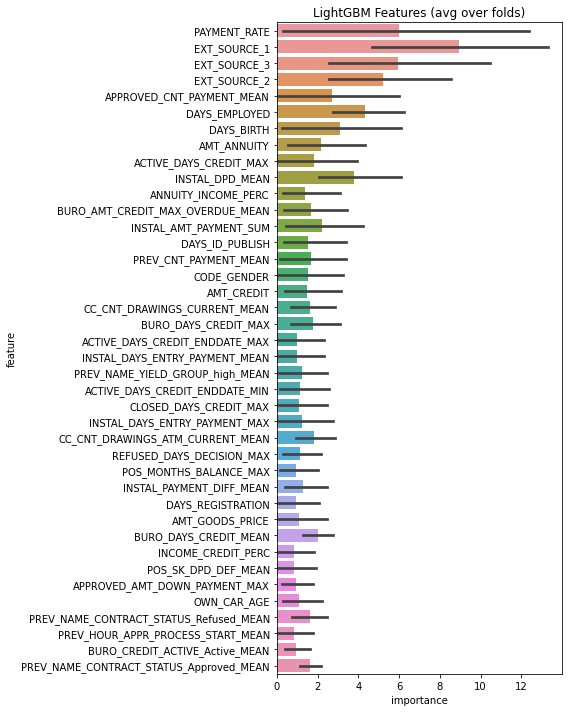

In [38]:
display_importances(feature_importance_df)

In [39]:
valid_y.shape

(30750,)

In [40]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28193,   104],
       [ 2392,    61]])

In [41]:
pd.crosstab(valid_y, valid_preds)

col_0,0.0,1.0
TARGET,,
0.0,28193,104
1.0,2392,61


## Old Results from Kaggle Parameters

In [28]:
valid_y.shape

(30750,)

In [27]:
valid_preds.shape

(30750,)

In [34]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28190,   107],
       [ 2293,   160]])

In [42]:
pd.crosstab(valid_y, valid_preds)

col_0,0.0,1.0
TARGET,,
0.0,28190,107
1.0,2293,160


In [30]:
tn, fp, fn, tp = confusion_matrix(valid_y, valid_preds).ravel()

In [31]:
tn

28190

In [32]:
fp

107

In [39]:
fn

2293

In [40]:
tp

160

In [46]:
from sklearn.metrics import confusion_matrix


def my_comp_score(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be cforrectly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a navie model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = (gain - baseline) / (best - baseline)
    
    return score

In [47]:
from sklearn.metrics import fbeta_score, make_scorer
make_scorer(my_comp_score)

make_scorer(my_comp_score)

# Function Version

In [ ]:
    with timer("Run LightGBM with kfold"):
            submission_file_name = "submission_kernel02.csv"
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [ ]:


def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
  
  
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df